In [2]:
library(lme4)
library(afex)
library(emmeans)
library(dplyr)
library(ggplot2)
library(svglite)
library(lmtest)
library(tidyr)
library(MCMCglmm)
library(reshape)
library(gridExtra)
library(cowplot)
library(svglite)
library(data.table)

Loading required package: Matrix

************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- Get and set global package options with: afex_options()
- Set sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************


Attaching package: ‘afex’


The following object is masked from ‘package:lme4’:

    lmer



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘tidyr’


The following objects 

In [3]:
control <- c(203,208,209,210,214,217,221,224)
ITI <- read.csv('/home/bagotlab/eshaan.i/PRL/FP_PRL_Nov_2021/Code/Longform Data/CondensedOneLever_ZScore_ITI.csv')
ITI$PRL <- as.factor(ifelse(is.element(ITI$ID,control),'Control','PRL'))
ITI = subset(ITI, (ID!=223)& (PRL!='Control'))
ITI$time_idx <- as.factor(as.numeric(as.factor(ITI$time)))
ITI<-ITI[,c('index','time_idx','time','ID','rewards','lp','Day','rt','PFC','vHIP')]
ITI$sex <- as.factor(ifelse(ITI$ID > 212,"Female", "Male"))
ITI$Day <- as.numeric(as.factor(ITI$Day))

ITI = subset(ITI, lp > 0)
ITI$time_idx <- as.factor(as.numeric(as.factor(ITI$time)))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Previous.Reward = lag(rewards,n=240))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Next.Reward = lead(rewards,n=240))
#created lagged dataframe where t2 is now t1
ITI2<-ITI[!is.na(ITI$Previous.Reward),]
ITI<-ITI %>% group_by(ID,Day) %>% mutate(DualTrialTime_Idx = rep_len(1:480, length.out=n()),DualTrial_Idx=rep(1:ceiling(n()/480), each=480, length.out=n()))
ITI2<-ITI2 %>% group_by(ID,Day) %>% mutate(DualTrialTime_Idx = rep_len(1:480, length.out=n()),DualTrial_Idx=rep(1:ceiling(n()/480), each=480, length.out=n()))

ITI = ITI %>% group_by(ID,Day,DualTrial_Idx) %>% mutate(last = DualTrialTime_Idx[[length(DualTrialTime_Idx)]])
ITI2 = ITI2 %>% group_by(ID,Day,DualTrial_Idx) %>% mutate(last = DualTrialTime_Idx[[length(DualTrialTime_Idx)]])

#remove orphan trials
ITI = subset(ITI, last==480)
ITI2 = subset(ITI2, last==480)

ITI$DF <- 0
ITI2$DF <- 1

ITI = rbind(ITI,ITI2)
ITI <- ITI %>% mutate(NewIdx = paste(Day,ID,DualTrial_Idx,DF))
ITI$NewIdx = as.numeric(as.factor(ITI$NewIdx))
ITI<-ITI %>% group_by(NewIdx) %>% mutate(CompoundReward = as.factor(paste(rewards[1],Next.Reward[1])), R1 = as.factor(rewards[1]), R2=as.factor(Next.Reward[1]))

prechoice1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=1)&((ITI$DualTrialTime_Idx)<=40),] %>% group_by(NewIdx)%>%summarize(PFC_Pre1=mean(PFC),vHIP_Pre1=mean(vHIP)))
ITI = merge(ITI,prechoice1,by = 'NewIdx')

#calculate with baseline centered
ITI$PFC = ITI$PFC - ITI$PFC_Pre1
ITI$vHIP = ITI$vHIP - ITI$vHIP_Pre1
prechoice1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=1)&((ITI$DualTrialTime_Idx)<=40),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
enditi1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=200)&((ITI$DualTrialTime_Idx)<=240),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
prechoice2<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=241)&((ITI$DualTrialTime_Idx)<=280),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
enditi2<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=440)&((ITI$DualTrialTime_Idx)<=480),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))

In [4]:
plot_theme <- theme(axis.title=element_text(size=25,color='gray30'),
                    axis.line=element_line(color='gray30'),
                    axis.text.y=element_text(size=20,color='gray30'),
                    axis.text.x=element_text(size=20,color='gray30'),
                    legend.text=element_text(size=20),
                    legend.key.size=unit(2,'mm'),
                    panel.background=element_blank(),
                    panel.grid.major.y = element_blank(),
                    legend.position = 'none',
                    plot.margin = margin(0.5,0.5,0.5,0.5,'cm'),
                    strip.background = element_blank(),
                    strip.text = element_text(size=20,color='gray30')) 

plot_theme_PFC <- list(plot_theme, scale_color_manual(values=c('1.0'="#9E9E9E",'1.1'="#B51D1D",  '0.0'="#444444",'0.1'="#EC407A")),
                        scale_fill_manual(values=c('1.0'="#9E9E9E",'1.1'="#B51D1D",  '0.0'="#444444",'0.1'="#EC407A")),
                        scale_shape_manual(values=c('Male'=16,'Female'=17)))
plot_theme_vHIP <- list(plot_theme, scale_color_manual(values=c('1.0'="#9E9E9E" ,'1.1'="#F27E19", '0.0'="#444444",'0.1'="#FFC107")), 
                        scale_fill_manual(values=c('1.0'="#9E9E9E" ,'1.1'="#F27E19", '0.0'="#444444",'0.1'="#FFC107")),
                        scale_shape_manual(values=c('Male'=16,'Female'=17)))

In [ ]:
#plot one lever traces mPFC-NAc

PFC1Back = NULL
for (tm in 1:480){
myModel=lmer(PFC ~ R1*R2 +(1|ID)+(1|Day),data=subset(ITI, (DualTrialTime_Idx==tm)))
current_time = (tm/20)-2
PFC1Back= rbind(PFC1Back,cbind(time=current_time,as.data.frame(emmeans(myModel, ~ R1*R2))))
}

ggplot(data = PFC1Back)+
  geom_line(aes(time,emmean,group=interaction(R1,R2), colour=interaction(R1,R2)))+
  geom_ribbon(aes(x=time,y = emmean, ymin = emmean - SE, ymax = emmean + SE, fill = interaction(R1,R2)), alpha = .2)+
  xlab('Time from LP')+
  ylab('mPFC Activity')+
  geom_vline(xintercept=c(0,10,12,22), linetype="dotted", size = 1)+
  plot_theme_PFC

boundary (singular) fit: see help('isSingular')

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 9524' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 9524)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 9524' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 9524)' or larger];
but be warned that this may result in large computation time and memory use.



,R1,R2,emmean,SE,df,asymp.LCL,asymp.UCL
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0.13866424,0.010050051,Inf,0.11896650,0.15836198
2,1,0,0.05035174,0.009661157,Inf,0.03141622,0.06928726
3,0,1,-0.12406217,0.009667135,Inf,-0.14300941,-0.10511494
4,1,1,-0.11343760,0.009569803,Inf,-0.13219407,-0.09468113


Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,R2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R10 - R11,0,0.08831250,0.01391463,Inf,6.3467389,4.398539e-10
2,R10 - R11,1,-0.01062458,0.01357564,Inf,-0.7826204,6.794742e-01
,contrast,R1,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R20 - R21,0,0.2627264,0.01391879,Inf,18.87567,0
2,R20 - R21,1,0.1637893,0.01357139,Inf,12.06872,0


`summarise()` has grouped output by 'ID', 'R1', 'R2'. You can override using
the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (geom_point).”


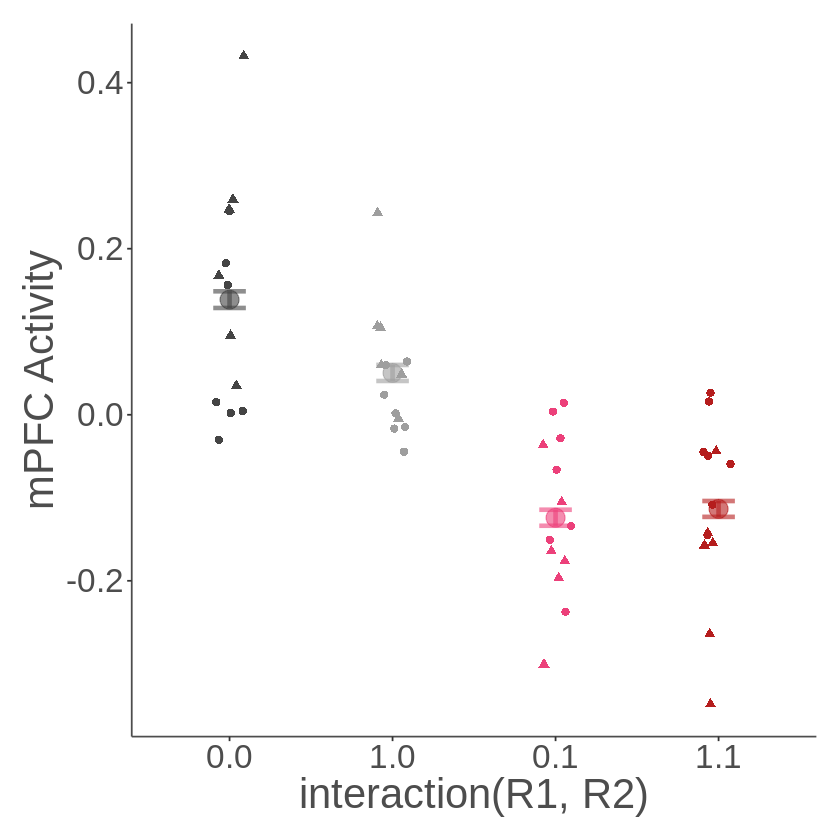

In [5]:
#Quantify one lever mPFC-NAc outcome encoding on trial t0

PFC_rewards_enditi <- lmer(PFC~R1*R2+(1|Day)+(1|ID), REML=TRUE ,data = enditi2)
PFC_rewards_enditi_means <- emmeans(PFC_rewards_enditi, ~ R1*R2)
summary(PFC_rewards_enditi_means)

dtf <- PFC_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
Bulk <- enditi2 %>% group_by(ID, R1,R2,sex) %>% summarise(PFC=mean(PFC, na.rm = TRUE))
dtf<- data.frame(dtf)

ggplot(dtf) +
  geom_point( aes(x=interaction(R1,R2), y=emmean, color=interaction(R1,R2)), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=interaction(R1,R2), ymin=emmean-SE, ymax=emmean+SE,color=interaction(R1,R2)), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = interaction(R1,R2), y = PFC, color = interaction(R1,R2), shape=sex), size = 2, width = 0.1) +
  ylab('mPFC Activity')+
  plot_theme_PFC

In [ ]:
#plot one lever traces vHIP-NAc

vHIP1Back = NULL
for (tm in 1:480){
myModel=lmer(vHIP ~ R1*R2 +(1|ID)+(1|Day),data=subset(ITI, (DualTrialTime_Idx==tm)))
current_time = (tm/20)-2
vHIP1Back= rbind(vHIP1Back,cbind(time=current_time,as.data.frame(emmeans(myModel, ~ R1*R2))))
}

ggplot(data = vHIP1Back)+
  geom_line(aes(time,emmean,group=interaction(R1,R2), colour=interaction(R1,R2)))+
  geom_ribbon(aes(x=time,y = emmean, ymin = emmean - SE, ymax = emmean + SE, fill = interaction(R1,R2)), alpha = .2)+
  xlab('Time from LP')+
  ylab('vHip Activity')+
  geom_vline(xintercept=c(0,10,12,22), linetype="dotted", size = 1)+
  plot_theme_vHIP

In [6]:
#Quantify one lever vHIP-NAc outcome encoding on trial t0

vHIP_rewards_enditi <- lmer(vHIP~R1*R2+(1|Day)+(1|ID), REML=TRUE ,data = enditi2)
vHIP_rewards_enditi_means <- emmeans(vHIP_rewards_enditi, ~ R1*R2)
summary(vHIP_rewards_enditi)

dtf <- vHIP_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
Bulk <- enditi2 %>% group_by(ID, R1,R2,sex) %>% summarise(vHIP=mean(vHIP, na.rm = TRUE))
dtf<- data.frame(dtf)
fig<-ggplot(dtf) +
  geom_point( aes(x=interaction(R1,R2), y=emmean, color=interaction(R1,R2)), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=interaction(R1,R2), ymin=emmean-SE, ymax=emmean+SE,color=interaction(R1,R2)), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = interaction(R1,R2), y = vHIP, color = interaction(R1,R2), shape=sex), size = 2, width = 0.1) +
  ylab('vHip Activity')+
  plot_theme_vHIP

boundary (singular) fit: see help('isSingular')

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 10332' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 10332)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 10332' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 10332)' or larger];
but be warned that this may result in large computation time and memory use.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: vHIP ~ R1 * R2 + (1 | Day) + (1 | ID)
   Data: enditi2

REML criterion at convergence: 13115.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.4738 -0.4888  0.0048  0.4919  5.9763 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 0.0001934 0.01391 
 Day      (Intercept) 0.0000000 0.00000 
 Residual             0.2077040 0.45575 
Number of obs: 10332, groups:  ID, 14; Day, 3

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  7.994e-02  1.003e-02  1.133e+02   7.970 1.38e-12 ***
R11         -8.036e-02  1.287e-02  1.033e+04  -6.242 4.48e-10 ***
R21         -1.098e-01  1.288e-02  1.033e+04  -8.525  < 2e-16 ***
R11:R21      5.904e-02  1.796e-02  1.033e+04   3.288  0.00101 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) R11    R21   
R11     

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,R2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R10 - R11,0,0.08036068,0.01287321,Inf,6.242476,8.613941e-10
2,R10 - R11,1,0.02131914,0.01252661,Inf,1.701908,1.696647e-01
,contrast,R1,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R20 - R21,0,0.10977901,0.01287802,Inf,8.524527,0.0000000000
2,R20 - R21,1,0.05073747,0.01252194,Inf,4.051885,0.0001016107


`summarise()` has grouped output by 'ID', 'R1', 'R2'. You can override using
the `.groups` argument.


In [8]:
#No lever

control <- c(203,208,209,210,214,217,221,224)
ITI <- read.csv('/home/bagotlab/eshaan.i/PRL/FP_PRL_Nov_2021/Code/Longform Data/CondensedNoLever_ZScore_ITI.csv')
ITI$PRL <- as.factor(ifelse(is.element(ITI$ID,control),'Control','PRL'))
ITI = subset(ITI, (ID!=223)& (PRL!='Control'))
ITI$time_idx <- as.factor(as.numeric(as.factor(ITI$time)))
ITI<-ITI[,c('index','time_idx','time','ID','rewards','lp','Day','rt','PFC','vHIP')]
ITI$sex <- as.factor(ifelse(ITI$ID > 212,"Female", "Male"))
ITI$Day <- as.numeric(as.factor(ITI$Day))

ITI$time_idx <- as.factor(as.numeric(as.factor(ITI$time)))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Previous.Reward = lag(rewards,n=240))
ITI<- ITI %>% group_by(ID,Day) %>% mutate(Next.Reward = lead(rewards,n=240))
#created lagged dataframe where t2 is now t1
ITI2<-ITI[!is.na(ITI$Previous.Reward),]
ITI<-ITI %>% group_by(ID,Day) %>% mutate(DualTrialTime_Idx = rep_len(1:480, length.out=n()),DualTrial_Idx=rep(1:ceiling(n()/480), each=480, length.out=n()))
ITI2<-ITI2 %>% group_by(ID,Day) %>% mutate(DualTrialTime_Idx = rep_len(1:480, length.out=n()),DualTrial_Idx=rep(1:ceiling(n()/480), each=480, length.out=n()))

ITI = ITI %>% group_by(ID,Day,DualTrial_Idx) %>% mutate(last = DualTrialTime_Idx[[length(DualTrialTime_Idx)]])
ITI2 = ITI2 %>% group_by(ID,Day,DualTrial_Idx) %>% mutate(last = DualTrialTime_Idx[[length(DualTrialTime_Idx)]])

#remove orphan trials
ITI = subset(ITI, last==480)
ITI2 = subset(ITI2, last==480)

ITI$DF <- 0
ITI2$DF <- 1

ITI = rbind(ITI,ITI2)
ITI <- ITI %>% mutate(NewIdx = paste(Day,ID,DualTrial_Idx,DF))
ITI$NewIdx = as.numeric(as.factor(ITI$NewIdx))
ITI<-ITI %>% group_by(NewIdx) %>% mutate(CompoundReward = as.factor(paste(rewards[1],Next.Reward[1])), R1 = as.factor(rewards[1]), R2=as.factor(Next.Reward[1]))

prechoice1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=1)&((ITI$DualTrialTime_Idx)<=40),] %>% group_by(NewIdx)%>%summarize(PFC_Pre1=mean(PFC),vHIP_Pre1=mean(vHIP)))
ITI = merge(ITI,prechoice1,by = 'NewIdx')

#calculate with baseline centered
ITI$PFC = ITI$PFC - ITI$PFC_Pre1
ITI$vHIP = ITI$vHIP - ITI$vHIP_Pre1
prechoice1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=1)&((ITI$DualTrialTime_Idx)<=40),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
enditi1<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=200)&((ITI$DualTrialTime_Idx)<=240),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
prechoice2<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=241)&((ITI$DualTrialTime_Idx)<=280),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))
enditi2<- as.data.frame(ITI[((ITI$DualTrialTime_Idx)>=440)&((ITI$DualTrialTime_Idx)<=480),] %>% group_by(NewIdx)%>%summarize(PFC=mean(PFC),vHIP=mean(vHIP),R1=first(R1), R2=first(R2), ID=as.factor(mean(ID)),Day=as.factor(mean(Day)), sex=first(sex)))

In [9]:
#plot no lever traces mPFC-NAc

PFC1Back = NULL
for (tm in 1:480){
myModel=lmer(PFC ~ R1*R2 +(1|ID)+(1|Day),data=subset(ITI, (DualTrialTime_Idx==tm)))
current_time = (tm/20)-2
PFC1Back= rbind(PFC1Back,cbind(time=current_time,as.data.frame(emmeans(myModel, ~ R1*R2))))
}

ggplot(data = PFC1Back)+
  geom_line(aes(time,emmean,group=interaction(R1,R2), colour=interaction(R1,R2)))+
  geom_ribbon(aes(x=time,y = emmean, ymin = emmean - SE, ymax = emmean + SE, fill = interaction(R1,R2)), alpha = .2)+
  xlab('Time from LP')+
  ylab('mPFC Activity')+
  geom_vline(xintercept=c(0,10,12,22), linetype="dotted", size = 1)+
  plot_theme_PFC

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 9872' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 9872)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 9872' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 9872)' or larger];
but be warned that this may result in large computation time and memory use.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: PFC ~ R1 * R2 + (1 | Day) + (1 | ID)
   Data: enditi2

REML criterion at convergence: 10262.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.6105 -0.3557  0.0131  0.3582  9.0200 

Random effects:
 Groups   Name        Variance  Std.Dev.
 ID       (Intercept) 3.486e-04 0.018672
 Day      (Intercept) 3.629e-05 0.006024
 Residual             1.649e-01 0.406099
Number of obs: 9872, groups:  ID, 13; Day, 3

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  3.458e-02  1.040e-02  1.917e+01   3.325  0.00353 ** 
R11         -1.359e-02  1.166e-02  9.783e+03  -1.166  0.24353    
R21         -9.568e-02  1.165e-02  9.779e+03  -8.214 2.42e-16 ***
R11:R21      9.567e-03  1.636e-02  9.862e+03   0.585  0.55862    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) R11    R21   
R11     -0

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,R2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R10 - R11,0,0.013593779,0.01165557,Inf,1.1662902,0.4277034
2,R10 - R11,1,0.004026705,0.01152883,Inf,0.3492727,0.9254080
,contrast,R1,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R20 - R21,0,0.09568309,0.01164933,Inf,8.213611,4.440892e-16
2,R20 - R21,1,0.08611601,0.01153642,Inf,7.464711,1.669775e-13


`summarise()` has grouped output by 'ID', 'R1', 'R2'. You can override using
the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (geom_point).”


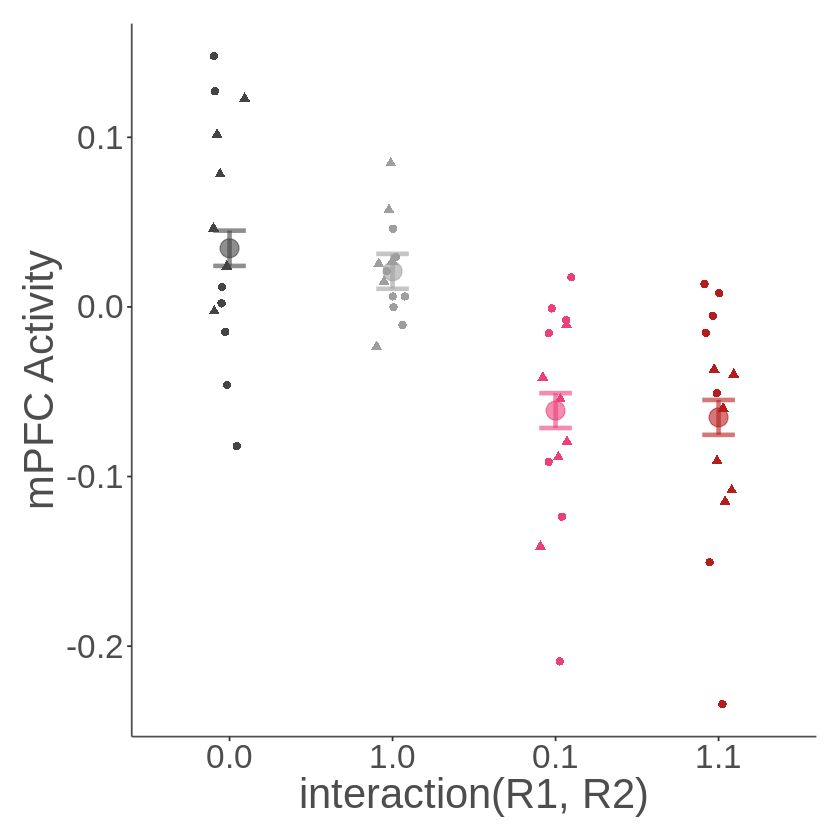

In [12]:
#Quantify one lever mPFC-NAc outcome encoding on trial t0

PFC_rewards_enditi <- lmer(PFC~R1*R2+(1|Day)+(1|ID), REML=TRUE ,data = enditi2)
PFC_rewards_enditi_means <- emmeans(PFC_rewards_enditi, ~ R1*R2)
summary(PFC_rewards_enditi)

dtf <- PFC_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
Bulk <- enditi2 %>% group_by(ID, R1,R2,sex) %>% summarise(PFC=mean(PFC, na.rm = TRUE))
dtf<- data.frame(dtf)
ggplot(dtf) +
  geom_point( aes(x=interaction(R1,R2), y=emmean, color=interaction(R1,R2)), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=interaction(R1,R2), ymin=emmean-SE, ymax=emmean+SE,color=interaction(R1,R2)), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = interaction(R1,R2), y = PFC, color = interaction(R1,R2), shape=sex), size = 2, width = 0.1) +
  ylab('mPFC Activity')+
  plot_theme_PFC

In [ ]:
#plot no lever traces vHIP-NAc 

vHIP1Back = NULL
for (tm in 1:480){
myModel=lmer(vHIP ~ R1*R2 +(1|ID)+(1|Day),data=subset(ITI, (DualTrialTime_Idx==tm)))
current_time = (tm/20)-2
vHIP1Back= rbind(vHIP1Back,cbind(time=current_time,as.data.frame(emmeans(myModel, ~ R1*R2))))
}

fig4<-ggplot(data = vHIP1Back)+
  geom_line(aes(time,emmean,group=interaction(R1,R2), colour=interaction(R1,R2)))+
  geom_ribbon(aes(x=time,y = emmean, ymin = emmean - SE, ymax = emmean + SE, fill = interaction(R1,R2)), alpha = .2)+
  xlab('Time from LP')+
  ylab('vHip Activity')+
  geom_vline(xintercept=c(0,10,12,22), linetype="dotted", size = 1)+
  plot_theme_vHIP

boundary (singular) fit: see help('isSingular')

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 10694' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 10694)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 10694' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 10694)' or larger];
but be warned that this may result in large computation time and memory use.



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: vHIP ~ R1 * R2 + (1 | Day) + (1 | ID)
   Data: enditi2

REML criterion at convergence: 9957.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.9289 -0.3973 -0.0094  0.3716  9.6270 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 ID       (Intercept) 8.310e-18 2.883e-09
 Day      (Intercept) 6.099e-06 2.470e-03
 Residual             1.482e-01 3.849e-01
Number of obs: 10694, groups:  ID, 14; Day, 3

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  2.346e-02  7.706e-03  2.793e+01   3.044 0.005040 ** 
R11         -4.099e-02  1.060e-02  1.069e+04  -3.866 0.000111 ***
R21         -3.965e-02  1.060e-02  1.069e+04  -3.741 0.000184 ***
R11:R21      2.365e-02  1.489e-02  1.069e+04   1.588 0.112309    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        (Intr) R11    R21   
R11  

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,contrast,R2,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R10 - R11,0,0.04099417,0.01060337,Inf,3.866144,0.0002211267
2,R10 - R11,1,0.01734363,0.01045787,Inf,1.658429,0.1850080623
,contrast,R1,estimate,SE,df,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,R20 - R21,0,0.03964883,0.01059760,Inf,3.741303,0.0003661043
2,R20 - R21,1,0.01599829,0.01046372,Inf,1.528929,0.2366169163


`summarise()` has grouped output by 'ID', 'R1', 'R2'. You can override using
the `.groups` argument.
Warning message:
“Removed 4 rows containing missing values (geom_point).”


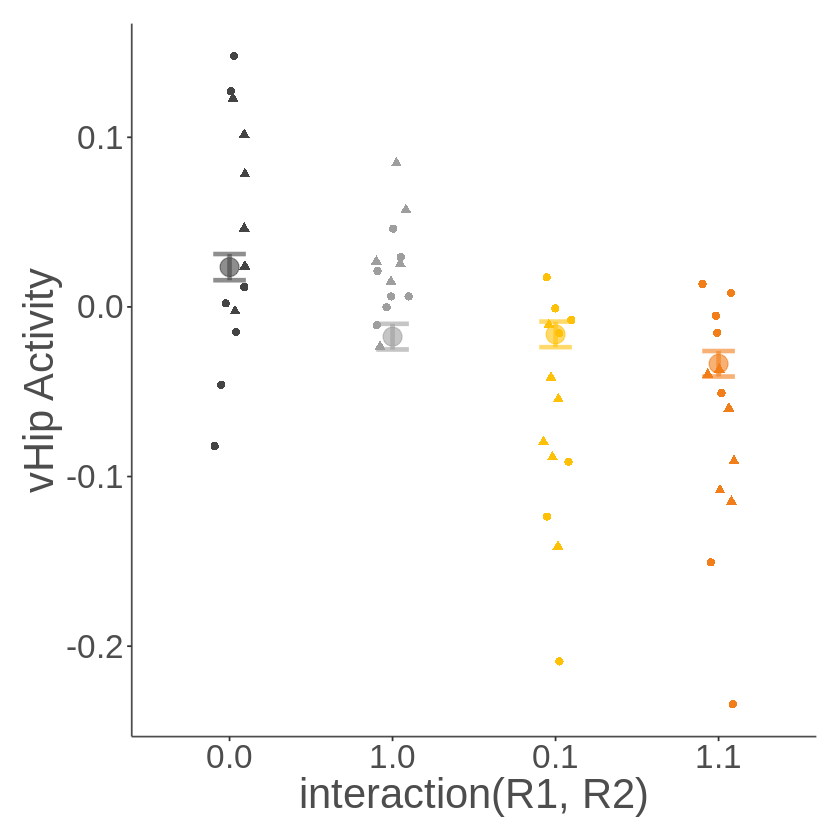

In [16]:
#Quantify one lever vHIP-NAc outcome encoding on trial t0

vHIP_rewards_enditi <- lmer(vHIP~R1*R2+(1|Day)+(1|ID), REML=TRUE ,data = enditi2)
vHIP_rewards_enditi_means <- emmeans(vHIP_rewards_enditi, ~ R1*R2)
summary(vHIP_rewards_enditi)

dtf <- vHIP_rewards_enditi_means
simp <- pairs(dtf, simple = "each")
test(simp, by = NULL)
Bulk <- enditi2 %>% group_by(ID, R1,R2,sex) %>% summarise(PFC=mean(PFC, na.rm = TRUE))
dtf<- data.frame(dtf)

ggplot(dtf) +
  geom_point( aes(x=interaction(R1,R2), y=emmean, color=interaction(R1,R2)), stat="identity", size = 5, alpha=0.6) +
  geom_errorbar( aes(x=interaction(R1,R2), ymin=emmean-SE, ymax=emmean+SE,color=interaction(R1,R2)), width=0.2, alpha=0.6, size=1.3) +
  geom_jitter(data=Bulk, aes(x = interaction(R1,R2), y = PFC, color = interaction(R1,R2), shape=sex), size = 2, width = 0.1) +
  ylab('vHip Activity')+
  plot_theme_vHIP